[Iteration 0/300] Loss: 109593680.0000 | Progress: 0.00%
[Iteration 10/300] Loss: 15754215.0000 | Progress: 3.33%
[Iteration 20/300] Loss: 7771631.0000 | Progress: 6.67%
[Iteration 30/300] Loss: 4631252.0000 | Progress: 10.00%
[Iteration 40/300] Loss: 3145778.5000 | Progress: 13.33%
[Iteration 50/300] Loss: 2364976.7500 | Progress: 16.67%
[Iteration 60/300] Loss: 1917400.7500 | Progress: 20.00%
[Iteration 70/300] Loss: 1632760.0000 | Progress: 23.33%
[Iteration 80/300] Loss: 1439147.2500 | Progress: 26.67%
[Iteration 90/300] Loss: 1299208.1250 | Progress: 30.00%
[Iteration 100/300] Loss: 1193065.6250 | Progress: 33.33%
[Iteration 110/300] Loss: 1109090.6250 | Progress: 36.67%
[Iteration 120/300] Loss: 1040399.7500 | Progress: 40.00%
[Iteration 130/300] Loss: 982455.5625 | Progress: 43.33%
[Iteration 140/300] Loss: 933049.1875 | Progress: 46.67%
[Iteration 150/300] Loss: 890322.0625 | Progress: 50.00%
[Iteration 160/300] Loss: 879886.3750 | Progress: 53.33%
[Iteration 170/300] Loss: 831

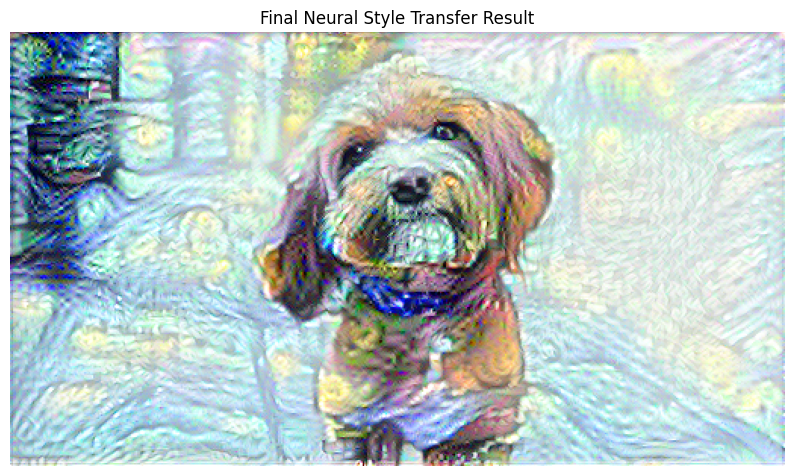

Stylized image saved as 'stylized_output.jpg'


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    shape = tf.shape(input_tensor)
    num_locations = tf.cast(shape[1] * shape[2], tf.float32)
    return result / num_locations

content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_style_layers = len(style_layers)

vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
model = tf.keras.Model([vgg.input], outputs)

def compute_loss(outputs, content_targets, style_targets, image):
    style_outputs = outputs[:num_style_layers]
    content_outputs = outputs[num_style_layers:]

    style_loss = 0
    for output, target in zip(style_outputs, style_targets):
        style_loss += tf.reduce_mean((gram_matrix(output) - target) ** 2)

    content_loss = tf.reduce_mean((content_outputs[0] - content_targets[0]) ** 2)

    style_loss *= 1e-3
    content_loss *= 1e2

    total_variation_weight = 1e-6
    tv_loss = total_variation_weight * tf.reduce_sum(tf.image.total_variation(image))

    total_loss = style_loss + content_loss + tv_loss
    return total_loss

optimizer = tf.optimizers.Adam(learning_rate=0.02)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:

        preprocessed_image = preprocess_input(image * 255.0)
        outputs = model(preprocessed_image)

        loss = compute_loss(outputs, content_targets, style_targets, image)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

    return loss

content_path = "/content/GettyImages-598175960-cute-dog-headshot.jpg"
style_path = "/content/images.jpg"

content_image = load_img(content_path)
style_image = load_img(style_path)

content_image_vgg = preprocess_input(content_image * 255.0)
style_image_vgg = preprocess_input(style_image * 255.0)

content_targets = model(content_image_vgg)[-1:]
style_outputs = model(style_image_vgg)[:num_style_layers]
style_targets = [gram_matrix(style) for style in style_outputs]

generated_image = tf.Variable(content_image)

epochs = 300

for i in range(epochs):
    loss = train_step(generated_image)

    if i % 10 == 0:
        progress = (i / epochs) * 100
        print(f"[Iteration {i}/{epochs}] "
              f"Loss: {loss.numpy():.4f} | "
              f"Progress: {progress:.2f}%")

print("\nNeural Style Transfer Completed Successfully!")

plt.figure(figsize=(10, 10))
plt.imshow(generated_image[0])
plt.axis('off')
plt.title("Final Neural Style Transfer Result")
plt.show()

final_img = tf.keras.utils.array_to_img(generated_image[0])
final_img.save("stylized_output.jpg")

print("Stylized image saved as 'stylized_output.jpg'")